# For Training and Loading the Pretrained Model on a Fresh Dataset

In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread
from keras.layers import Input
import tensorflow as tf
import tensorflow_hub as hub
# import tf.keras.callbacks 

In [2]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.9.2
Hub version: 0.12.0
GPU available


In [3]:
# # Running this cell will provide you with a token to link your drive to this notebook
from google.colab import drive
import sys

drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/Datathon/')

Mounted at /content/gdrive/


In [4]:
%cd '/content/gdrive/My Drive/Datathon/'

/content/gdrive/.shortcut-targets-by-id/18Pjuiby86W8tPsgJuQAMo0AMjzsG0pLw/Datathon


In [5]:
!ls

'~'				        models
 Datathon2.ipynb		        models_archit
 datathonindoml-2022.zip	       'New Models.ipynb'
 dense-net-logger.csv		        predicted_label_3.csv
 drive				        predicted_label.csv
 efficient-net-logger.csv	       'rekhani LSTM.ipynb'
'few shot.ipynb'		        res-net-logger.csv
'for RESNETS.ipynb'		        sample_submission.csv
 full_np_array.npy		        train
 kaggle-indoml-submission.csv	        train_labels.csv
 kaggle-indoml-submission-model-2.csv   validation
 logs				       'Vision Transformers.ipynb'
 mobile-net-logger.csv		        vision-trans-logger.csv
 mobile-net-logger.gsheet


In [6]:
train_labels_csv = pd.read_csv("train_labels.csv")

In [7]:
labels = train_labels_csv["label"].to_numpy() # convert labels column to NumPy array (from Training Dataset)
# Finding the unique labels
unique_labels = np.unique(labels)
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_labels) for label in labels]


In [8]:
boolean_labels[:5]

[array([False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False]),
 array([False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False])]

In [9]:
# Create pathnames from image ID's
train_path = "train/train/"
filenames = [train_path + str(fname) + ".jpeg" for fname in train_labels_csv["id"]]      # Fetching training files' IDs from train_labels_csv

val_path = "validation/validation/"
val_filenames = [val_path + str(fname) for fname in os.listdir(val_path)]       # Fetching Validation files' IDs from the validation set

In [10]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [11]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=1)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [12]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [13]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [14]:
# Turn full training data in a data batch
full_data = create_data_batches(X, y)

Creating training data batches...


In [15]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_labels) # number of unique labels

# Setup model URL from TensorFlow Hub
# MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"
# MODEL_URL ="https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2"
# MODEL_URL ="https://tfhub.dev/google/supcon/resnet_v1_200/imagenet/classification/1"


In [16]:
# # ONLY FOR DENSE-NETS
# import keras
# from keras.models import Model
# from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, BatchNormalization, concatenate, AveragePooling2D
# from keras.optimizers import Adam



# def conv_layer(conv_x, filters):
#     conv_x = BatchNormalization()(conv_x)
#     conv_x = Activation('relu')(conv_x)
#     conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
#     conv_x = Dropout(0.2)(conv_x)

#     return conv_x


# def dense_block(block_x, filters, growth_rate, layers_in_block):
#     for i in range(layers_in_block):
#         each_layer = conv_layer(block_x, growth_rate)
#         block_x = concatenate([block_x, each_layer], axis=-1)
#         filters += growth_rate

#     return block_x, filters


# def transition_block(trans_x, tran_filters):
#     trans_x = BatchNormalization()(trans_x)
#     trans_x = Activation('relu')(trans_x)
#     trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
#     trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

#     return trans_x, tran_filters


# def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
#     input_img = Input(shape=(224, 224, 3))
#     x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

#     dense_x = BatchNormalization()(x)
#     dense_x = Activation('relu')(x)

#     dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
#     for block in range(dense_block_size - 1):
#         dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
#         dense_x, filters = transition_block(dense_x, filters)

#     dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
#     dense_x = BatchNormalization()(dense_x)
#     dense_x = Activation('relu')(dense_x)
#     dense_x = GlobalAveragePooling2D()(dense_x)

#     output = Dense(classes, activation='softmax')(dense_x)

#     return Model(input_img, output)

In [17]:
# we will build the model using the Keras API

def create_model(model_url, input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
  print("Building the model with:", model_url)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(model_url), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer). Softmax will predict the probabilities for each class for each image
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # An optimizer helping our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model

## Creating the Model 2 for Full data Training

In [18]:
# full_model2=lstm wala model

In [62]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv2D, TimeDistributed
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import SGD


In [20]:
epochs = 30;

Running the follwing block may take significant amount of time

In [21]:
# full_np_array = [process_image(i) for i in filenames]

In [ ]:
# full_np_array=np.array(full_np_array)
# np.save("full_np_array.npy", full_np_array, allow_pickle=True, fix_imports=True)
# tf.io.write_file("full_tensor", full_np_array)
# len(full_np_array)

In [137]:
X = np.load("full_np_array.npy")
X[0]

array([[[0.41814008],
        [0.98974156],
        [1.        ],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]],

       [[0.5057433 ],
        [0.9972164 ],
        [1.        ],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]],

       ...,

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]],

       [[0.9970764 ],
        [0.993855  ],
        [0.9971464 ],
        ...,
        [0.9985813 ],
        [0.9996356 ],
        [1.        ]],

       [[1.        ],
        [0.99907213],
        [0.9847455 ],
        ...,
        [0.9981501 ],
        [0.8721236 ],
        [1.        ]]], dtype=float32)

In [31]:
print(X.shape)

(16000, 224, 224, 1)
(16000, 224, 224, 1)


In [180]:
size = 5000
X_train, X_test, y_train, y_test = train_test_split(X[:size], labels[:size], test_size=0.20, random_state=42)

In [181]:
def standardize(train, test):
    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

X_train, X_test = standardize(X_train, X_test)
# np.linalg.norm(X_train[0]-np.ones((224,224,1), dtype = np.float32))
# print(X_test.shape)
# print(y_train[0])
# print(y_test[0])

In [182]:
from keras.utils import to_categorical

def modify_dataset(X_train, Y_train, X_test, Y_test):
  X_train = tf.reshape(X_train,(len(X_train),IMG_SIZE,IMG_SIZE,1))
  X_test = tf.reshape(X_test,(len(X_test),IMG_SIZE,IMG_SIZE,1))
  Y_train = to_categorical(Y_train)
  Y_test = to_categorical(Y_test)
  return X_train, Y_train, X_test, Y_test

X_train, y_train, X_test, y_test = modify_dataset(X_train, y_train, X_test, y_test)

In [183]:

X_train[0]
import matplotlib.pyplot as plt
# print(y_test.head)
# print(y_train.head)

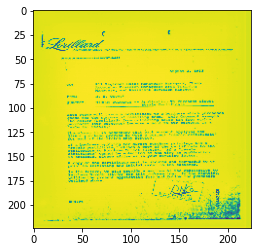

In [184]:
X_train = tf.reshape(X_train,(len(X_train),IMG_SIZE,IMG_SIZE))
X_test = tf.reshape(X_test,(len(X_test),IMG_SIZE,IMG_SIZE))
plt.imshow(X_train[0])

In [185]:
	model = Sequential()
	model.add(LSTM(32, activation='relu', kernel_initializer='he_uniform', input_shape=(IMG_SIZE, IMG_SIZE)))
	# model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(16, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [186]:
# compile model
# opt = SGD(lr=0.01, momentum=0.9)
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# cnn.summary()
model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 32)                32896     
                                                                 
 flatten_23 (Flatten)        (None, 32)                0         
                                                                 
 dense_41 (Dense)            (None, 100)               3300      
                                                                 
 dense_42 (Dense)            (None, 16)                1616      
                                                                 
Total params: 37,812
Trainable params: 37,812
Non-trainable params: 0
_________________________________________________________________


In [187]:

print(X_train.shape)
print(X_test.shape)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)
print(y_train[10])

(4000, 224, 224)
(1000, 224, 224)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(16,), dtype=float32)


In [188]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
32/32 [==============================] - 15s 433ms/step - loss: nan - accuracy: 0.0605 - val_loss: nan - val_accuracy: 0.0680
Epoch 2/10
 8/32 [======>.......................] - ETA: 10s - loss: nan - accuracy: 0.0586

KeyboardInterrupt: ignored

In [ ]:
_, acc = model.evaluate(X_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

In [ ]:
# # Instantiate a new model for training on the full dataset
full_model2 = model

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, so we monitor only training accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=4)

logger= tf.keras.callbacks.CSVLogger("rekhani-lstm-logger.csv")

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models_archit",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Fit the full model to the full training data
full_model2.fit(x=full_data,
               epochs=5,
               callbacks=[full_model_tensorboard, 
                          full_model_early_stopping, logger])

Epoch 1/5


ValueError: ignored

In [ ]:
# Save our model trained on 4000 images from the Training Dataset
# save_model(full_model2, suffix="res-net")
x=save_model(full_model2, suffix="rekhani-lstm")

In [ ]:
# check train and test data size

In [ ]:
# Load our model trained on 1000 images
# loaded_model = load_model('models_archit/20221112-02251668219959-res-net.h5')
loaded_model = load_model(x)

In [ ]:
X_val = X[:500]
y_val = y[:500]
val_data = create_data_batches(X_val, y_val, valid_data=True)

In [ ]:
# Evaluate the loaded model
loaded_model.evaluate(val_data)

In [ ]:
predictions = loaded_model.predict(val_data, verbose=1) 

In [ ]:
predictions.shape

In [ ]:
predictions=pd.DataFrame(predictions)
predictions.to_csv('drive/MyDrive/Datathon/approx_predicted_label_rekhani-lstm.csv')

In [ ]:
# # Turn prediction probabilities into their labels (Document Types)
# def get_pred_label(prediction_probabilities):
#   """
#   Turns an array of prediction probabilities into a label.
#   """
#   return unique_labels[np.argmax(prediction_probabilities)]


In [ ]:
# model_path = "models_archit/20221112-00031668211416-efficient-net.h5" 
# data_path = "validation/validation"

In [ ]:
# # Function to test the validation data stored in 'data_path' with the model stored in 'model_path'
# # here, model_path = "drive/MyDrive/Datathon/models/20221007-08281665131319-full-trained-adam.h5" 
# #       data_path = "drive/MyDrive/Datathon/validation/validation"

# def test(model_path, data_path):
#   # Load the fully trained model
#   loaded_full_model = load_model(model_path)

#   # Load validation image filenames
#   val_path = data_path
#   val_filenames = [val_path + fname for fname in os.listdir(val_path)]

#   # Getting the list of validation set IDs
#   val_id = [id for id in os.listdir(val_path)]
#   val_ids = []
#   for item in val_id:
#     val_ids.append(int(item.split(".")[0]))
  
#   # Create validation data batch so as to turn it into tensors and then fit it in our model
#   val_data = create_data_batches(val_filenames, test_data=True) 

#   # Make predictions on the validation data 
#   predictions = loaded_full_model.predict(val_data, verbose=1) 
  
#   # Getting the predicted labels in array val_pred_labels[]
#   val_pred_labels = []
#   for i in range(len(val_ids)):
#     val_pred_labels.append(get_pred_label(predictions[i]))
  
#   # Fitting the data into Pandas dataframe
#   data = []
#   for i in range(len(val_ids)):
#     data.append((val_ids[i], val_pred_labels[i]))
#   df = pd.DataFrame(data, columns=['id','label'])

#   # Saving the predicted labels on validation set images in CSV
#   # Saving the predictions to predicted_label.csv file and saving it inside the datathon folder in GDrive
#   # df.to_csv(r'drive/MyDrive/Datathon/predicted_label2.csv', index=False)

#   df.to_csv(r'predicted_label_mobile-net.csv', index=False)  
#   # df.to_csv(r'predicted_label_efficient-net.csv', index=False)  

In [ ]:
# test(model_path, data_path)

In [ ]:
# data= pd.read_csv('drive/MyDrive/Datathon/predicted_label.csv')
# data